Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Spencer Mui"
COLLABORATORS = ""

---

#### Below is the code to download the kaggle dataset if csv does not work

In [2]:
# Link: https://www.kaggle.com/datasets/yusufdelikkaya/datascience-salaries-2024?resource=download
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("yusufdelikkaya/datascience-salaries-2024")

#print("Path to dataset files:", path)

* - Denotes pieces of the project that will not be implemented but explained

1. Data Collection
Extract data from Kaggle data set 
Inject random unrelated variables/missing variables into dataset (for data cleaning)
Gather data from job boards *
Including job board listings would add more validity to the data set and add more data to interpret

2. Data Handling
Error handle potential defects from csv file
Remove extraneous data
Handle missing values in Pandas by removing data that cannot be interpreted
Delete duplicate data from job boards*
Job boards have many incorrect values and variables, many of which are not important for interpretation or completely invalidate the dataset. For example, job postings for internships that are actually full-time jobs and vice-versa can be incorrectly listed, leading to incorrect data and models.

3. Databases
Design SQL database to perpetually store collected data
Create Job_Posting to store data of job market, contains data such as posted date and job type * (Will be entered into the SQL database but will not contain any data inside)
Create Historic_Jobs to store data of disclosed salaries and relevant jobs information
Create structure to store collected data into SQL
Load existing data into the new database
Verify correctness of loaded data
Checks to make sure all the data entered into SQL is accurate, to test this, query SQL and check the first 3 lines are entered correctly

3. Modeling
Calculate mean and variance for data
Remove data outliers
Create Z-Score normalization of data
Split dataset into testing and prediction sets
Use linear regression to calculate prediction model
Visualize current data
Show the job markets with data science

4. Analysis
Use model to predict salaries over the next 5 years
Visualize prediction showing both historic and new data points
Create graphs to visualize the growth of jobs and salaries in the industry
Show the countries with a high demand for data science employees
Produce R2 Scores
Calculate the Mean Squared Error
Compare the historical data to the current prediction model

'''

In [2]:
# Needed import statements
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt # adjust this to get the proper graph from matlotlib

# SQL imports
import sqlite3
from sqlalchemy import create_engine, text

# imports for all metric testing and ML work
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### 1. Data Collection
Import csv file to pandas dataframe, add null data

In [3]:
df = pd.read_csv('DataScience_salaries_2024.csv')
df = df.drop(['company_size'], axis = 1) # Unrelated information

# Add incorrect data
# 15% of data will be incorrect and stored in different locations in the dataframe
df_size = len(df)
np.random.seed(9)
num_incorrect_indices = int(df_size * 0.15)
incorrect_indices = random.sample(range(df_size), num_incorrect_indices)
invalid_data = df.iloc[incorrect_indices].copy()
for index in range(len(invalid_data)):
    repeat_nan = random.randint(1, 3)
    for i in range(repeat_nan):
        invalid_data.iloc[index, [random.randint(0, 9)]] = np.nan

df = pd.concat([df, invalid_data], ignore_index = True)
print("Data Preview:\n", df.head())
print("Data Size:",len(df))

Data Preview:
    work_year experience_level employment_type                       job_title  \
0     2021.0               MI              FT                  Data Scientist   
1     2021.0               MI              FT                 BI Data Analyst   
2     2020.0               MI              FT                  Data Scientist   
3     2021.0               MI              FT                     ML Engineer   
4     2022.0               SE              FT  Lead Machine Learning Engineer   

       salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  30400000.0             CLP        40038.0                 CL         100.0   
1  11000000.0             HUF        36259.0                 HU          50.0   
2  11000000.0             HUF        35735.0                 HU          50.0   
3   8500000.0             JPY        77364.0                 JP          50.0   
4   7500000.0             INR        95386.0                 IN          50.0   

  company_l

### 2. Data Handling
Remove null or missing values 

In [4]:
missing_data = df.apply(lambda x: sum(x.isnull()), axis = 0)
print(missing_data)

null_rows = df.apply(lambda x: x.isnull())
#print(null_rows)

for i in range(len(df)):
    if (null_rows['work_year'][i] == True or null_rows['experience_level'][i] == True or
        null_rows['employment_type'][i] == True or null_rows['job_title'][i] == True or
        null_rows['salary'][i] == True or null_rows['salary_currency'][i] == True or
        null_rows['salary_in_usd'][i] == True or null_rows['employee_residence'][i] == True or
        null_rows['remote_ratio'][i] == True or null_rows['company_location'][i] == True):
        df = df.drop([i])
#print(df)
print(f'Removed amount of data: {len(null_rows) - len(df)}\nRemoved percent(~15%): {len(null_rows)/len(df) - 1}')

work_year             414
experience_level      419
employment_type       455
job_title             424
salary                410
salary_currency       417
salary_in_usd         398
employee_residence    458
remote_ratio          416
company_location      382
dtype: int64
Removed amount of data: 2225
Removed percent(~15%): 0.14995282383070485


### 3. Database
Create SQL database to store locally inside the project, load data into database

In [5]:
# Function for user to verify dataframe loaded into database
def check_input(connection, table):
    cursor = connection.execute(f'''SELECT * FROM {table} LIMIT 10''')
    rows = cursor.fetchall()
    for row in rows:
        print(row)

# Function to read in all data from database
def read_input(connection, table):
    cursor = connection.execute(f'''SELECT * FROM {table}''')
    rows = cursor.fetchall()
    return rows 

In [6]:
# Establish connection
connection = sqlite3.connect('ds_salaries.db')

engine = create_engine('sqlite:///ds_salaries.db')
df.to_sql('historic_data', con=engine, if_exists='replace', index=True, index_label='row_id') 

# Adding table for job_postings
cursor = connection.execute('''
CREATE TABLE IF NOT EXISTS job_postings(
    job_id INT PRIMARY KEY,
    job_date DATE,
    job_type VARCHAR(50),
    salary INT
);
''')

Run this code only if ds_salaries.db has not created the postings already

In [7]:
with engine.connect() as conn:
    with conn.begin():
        conn.execute(text('''INSERT INTO job_postings 
                                (job_id, job_date, job_type, salary)
                            VALUES 
                                (1, 2024-01-01, 'Entry-Level Data Scientist', 60000),
                                (2, 2024-02-01, 'Senior Data Scientist', 120000),
                                (3, 2024-03-01, 'Data Analyst', 85000);
                                '''))

In [8]:
print("Historic Jobs:")
check_input(connection, 'historic_data')

print("Job Postings: ")
check_input(connection, 'job_postings')

Historic Jobs:
(0, 2021.0, 'MI', 'FT', 'Data Scientist', 30400000.0, 'CLP', 40038.0, 'CL', 100.0, 'CL')
(1, 2021.0, 'MI', 'FT', 'BI Data Analyst', 11000000.0, 'HUF', 36259.0, 'HU', 50.0, 'US')
(2, 2020.0, 'MI', 'FT', 'Data Scientist', 11000000.0, 'HUF', 35735.0, 'HU', 50.0, 'HU')
(3, 2021.0, 'MI', 'FT', 'ML Engineer', 8500000.0, 'JPY', 77364.0, 'JP', 50.0, 'JP')
(4, 2022.0, 'SE', 'FT', 'Lead Machine Learning Engineer', 7500000.0, 'INR', 95386.0, 'IN', 50.0, 'IN')
(5, 2021.0, 'MI', 'FT', 'ML Engineer', 7000000.0, 'JPY', 63711.0, 'JP', 50.0, 'JP')
(6, 2021.0, 'SE', 'FT', 'Data Science Manager', 7000000.0, 'INR', 94665.0, 'IN', 50.0, 'IN')
(7, 2022.0, 'EN', 'FT', 'Data Scientist', 6600000.0, 'HUF', 17684.0, 'HU', 100.0, 'HU')
(8, 2022.0, 'EX', 'FT', 'Head of Machine Learning', 6000000.0, 'INR', 76309.0, 'IN', 50.0, 'IN')
(9, 2022.0, 'EN', 'FT', 'Research Engineer', 5500000.0, 'JPY', 41809.0, 'JP', 50.0, 'JP')
Job Postings: 
(1, 2022, 'Entry-Level Data Scientist', 60000)
(2, 2021, 'Senior 

### 4. Modeling
Download information from database and create linear regression for data analysis

In [9]:
# Load data from database
new_connection = sqlite3.connect('ds_salaries.db')
model_df = pd.read_sql_query("SELECT * FROM historic_data", new_connection)

# Find mean of salaries in USD
print(f'The average salary in USD for data science is: ${round(model_df["salary_in_usd"].mean(), 2)}')

# Finds the deviation of each row in the model from the standard (Z-Score Normalization)
standard_salary = (model_df["salary_in_usd"] - model_df["salary_in_usd"].mean())/model_df["salary_in_usd"].std()
print(model_df.shape)

# Remove any outliers from data
for i in range(len(df)):
    if standard_salary[i] > 3 or standard_salary[i] < -3:
        model_df = model_df.drop(index = i)
        
print(model_df.shape)

The average salary in USD for data science is: $149874.72
(14838, 11)
(14709, 11)


##### Important information about graphs
EN = Entry, MI = Mid-level, SE = Senior, EX = Expert (in order of lowest to highest experience)

Text(0, 0.5, 'Salary')

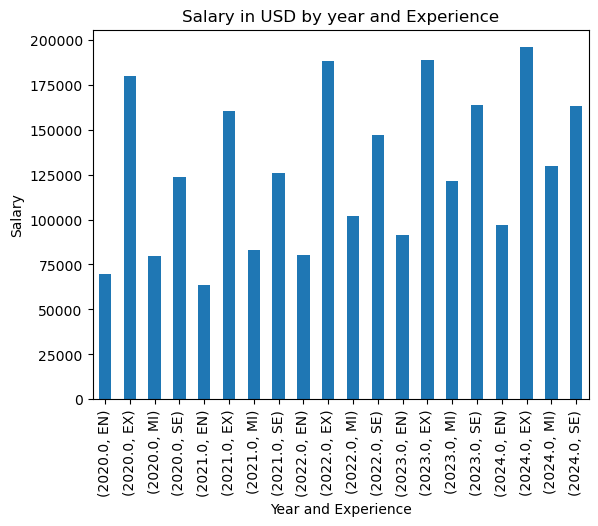

In [10]:
# Create current visualizations
grouped_df = model_df.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean()

# EN = Entry, MI = Mid-level, SE = Senior, EX = Expert (in order of highets to lowest salary
#print(grouped_df)
grouped_df.plot(kind='bar')
plt.title('Salary in USD by year and Experience')
plt.xlabel('Year and Experience')
plt.ylabel('Salary')

In [ ]:
# Plots a density graph that shows the salary spread across experience level
grouped2_df = model_df.groupby(['experience_level'])['salary_in_usd']

grouped2_df.plot(kind='density')
plt.xlim(-10000, 375000)
plt.legend(title='Experience Level')

### 5. Analysis
Create linear regression model, calculate R2 scores and error margins, predict salaries, visualize data 

In [12]:
# Craete linear regression model
correct_df = model_df[['experience_level']].copy()

encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(correct_df[['experience_level']]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns = ['EN', 'MI', 'SE', 'EX'])

#print(one_hot_encoded)

scaler = MinMaxScaler()
scaled_df = pd.concat([model_df[['salary_in_usd']], one_hot_encoded_df], axis=1, join='outer').fillna(0)
scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df), columns = scaled_df.columns)

#print(scaled_df)

X = scaled_df[['EN', 'MI', 'SE', 'EX']]
Y = scaled_df[['salary_in_usd']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

model = LinearRegression()
model.fit(X_train, Y_train)
Y_predict = model.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(Y_test, Y_predict):.2f}')
print(f"R2 Score: {r2_score(Y_test, Y_predict):.2f}")

prediction_df = pd.DataFrame(scaler.inverse_transform(scaled_df), columns = scaled_df.columns)

Mean Squared Error: 0.03
R2 Score: 0.16


In [13]:
def unencode(row):
    for c in prediction_df.columns:
        if row[c] == 1:
            return c

unencoded_df = prediction_df.apply(unencode, axis=1)
predcition_df = prediction_df.drop(['EN', 'MI', 'SE', 'EX'], axis=1)
prediction_df = pd.concat([predcition_df, unencoded_df], ignore_index = True, axis=1)
prediction_df.columns = ['salary_in_usd', 'experience_level']
print(prediction_df)

       salary_in_usd experience_level
0            40038.0               SE
1            36259.0               SE
2            35735.0               SE
3            77364.0               SE
4            95386.0               EX
...              ...              ...
14833            0.0               EX
14834            0.0               EX
14835            0.0               EX
14836            0.0               MI
14837            0.0               EX

[14838 rows x 2 columns]


In [ ]:
new_df = prediction_df.groupby(['experience_level'])['salary_in_usd']
new_df.plot(kind='density')
plt.xlim(-10000, 375000)
plt.legend(title='Experience Level')

experience_level
EN     95495.082825
EX    160307.608302
MI    178285.067130
SE    123346.404207
Name: salary_in_usd, dtype: float64


Text(0.5, 0, 'Experience Level')

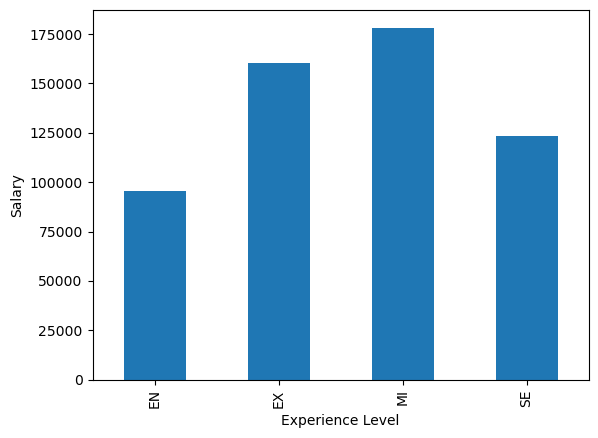

In [15]:
df2 = prediction_df.groupby(['experience_level'])['salary_in_usd'].mean()
print(df2)
df2.plot(kind='bar')
plt.ylabel('Salary')
plt.xlabel('Experience Level')

Text(0, 0.5, 'Salary')

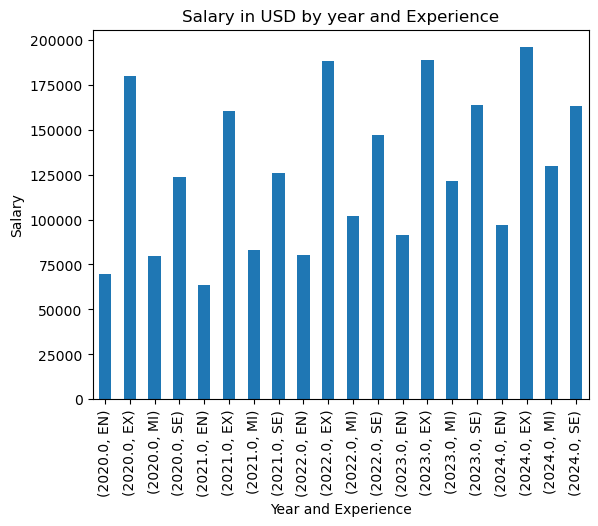

In [21]:
grouped_df.plot(kind='bar')
plt.title('Salary in USD by year and Experience')
plt.xlabel('Year and Experience')
plt.ylabel('Salary')